In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve, f1_score, recall_score, precision_score, confusion_matrix, davies_bouldin_score
from sklearn.metrics.cluster import v_measure_score 
import joblib 
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h2>Load Datasets</h2>

In [3]:
#Import Sussex Huawei dataset
df_acc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/sussex_acc.csv')
mad_acc_sussex = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/sussex_acc_mad.csv')

#Import dataset of 2014
accelerometer_2014 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/dataset_acc_2014.csv')
mad_acc_2014 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/dataset_acc_2014_mad.csv')

#Read data of the Accelerometer sensor 2022
accelerometer = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/dataset_acc.csv')
mad_acc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tp1_AI/dataset_acc_mad.csv')

<h2>Merge DataFrames</h2>

In [4]:
df = pd.merge(df_acc, mad_acc_sussex, on='instante', how='right', validate='m:1')
df_2014 = pd.merge(accelerometer_2014, mad_acc_2014, on=['id_recolha', 'instante'], validate='1:1')
df_acc_2022 = pd.merge(accelerometer, mad_acc, on=['id_recolha', 'instante'], validate='1:1')

<h2>Data Visualization</h2>

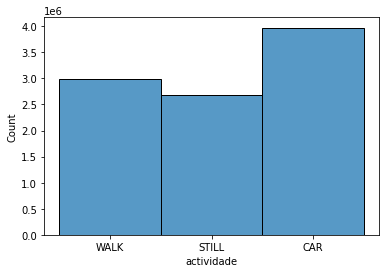

In [ ]:
sn.histplot(df['actividade'])

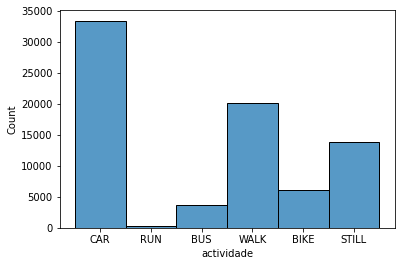

In [ ]:
sn.histplot(df_acc_2022['actividade'])

<h2>Pre-Processing</h2>

In [5]:
df.dropna(inplace=True)
df.drop(['instante'], axis=1, inplace=True)
df.shape

(9656981, 6)

In [6]:
df_acc_2022.dropna(inplace=True)
df_2014.dropna(inplace=True)

df_acc_2022.drop(['id_recolha', 'id_user', 'instante'], axis=1, inplace=True)
df_2014.drop(['id_recolha', 'instante'], axis=1, inplace=True)

In [7]:
df_classification = pd.concat([df_acc_2022,df_2014])
df_classification.shape

(3106647, 6)

In [8]:
df_classification.head()

,actividade,avg_values,min_values,max_values,std_values,mad
1,CAR,3.802188,3.517812,4.086563,0.402168,0.142188
2,CAR,3.652826,3.354102,4.086563,0.384443,0.099575
3,CAR,4.247412,3.354102,6.031169,1.229903,0.445939
4,CAR,4.660202,3.354102,6.311365,1.409424,0.330233
5,CAR,5.321628,3.354102,7.393691,1.795925,0.414413


In [9]:
dataset_sussex = df.sample(frac=0.15, random_state=1)

dataset_sussex.reset_index(inplace=True, drop=True)
dataset_sussex.shape

(1448547, 6)

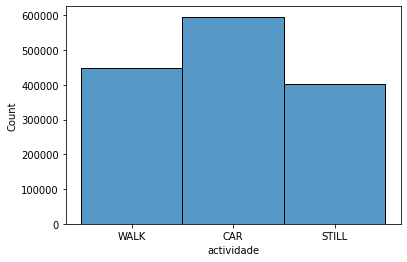

In [10]:
sn.histplot(dataset_sussex['actividade'])

<h2>Clustering</h2>

In [11]:
df_temp = df_classification.drop("actividade", axis=1)
df_transform = StandardScaler().fit_transform(df_temp)
df_transform = pd.DataFrame(df_transform)


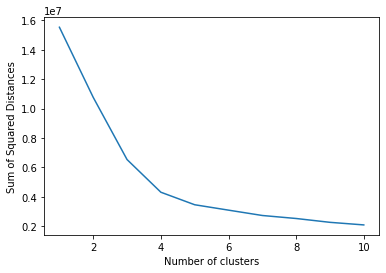

In [ ]:
sum_squares = [] 

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(df_transform)
    sum_squares.append(kmeans.inertia_)

plt.plot(range(1, 11), sum_squares)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

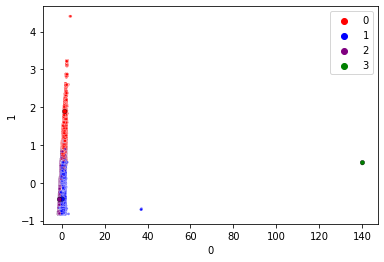

In [12]:
clustering = KMeans(n_clusters=4, max_iter=100, algorithm="elkan")

clustering.fit(df_transform)

labels = clustering.labels_
colors = ['red', 'blue', 'purple', 'green'] 


ax = sn.scatterplot(x=df_transform.iloc[:, 0], y=df_transform.iloc[:, 1], hue=labels, palette=colors, alpha=0.5, s=7)
ax = sn.scatterplot(x=clustering.cluster_centers_[:, 0], y=clustering.cluster_centers_[:, 1], 
                     hue=range(4), palette=colors, s=20, ec='black', legend=False, ax=ax)
plt.show()

In [13]:
df_classification['label'] = labels.tolist()

In [14]:
df_classification.groupby(['label','actividade']).count()

avg_values  min_values  max_values  std_values    mad
label actividade                                                       
0     BIKE               804         804         804         804    804
      CAR              10998       10998       10998       10998  10998
      STILL            11110       11110       11110       11110  11110
      WALK              1461        1461        1461        1461   1461
1     BIKE               236         236         236         236    236
      BUS                  3           3           3           3      3
      CAR               3724        3724        3724        3724   3724
      RUN                  1           1           1           1      1
      STILL             1343        1343        1343        1343   1343
      WALK              1445        1445        1445        1445   1445
2     BIKE              4991        4991        4991        4991   4991
      BUS               3705        3705        3705        3705   3705
      CAR              18732       18732       18732       18732  18732
      RUN                234         234         234         234    234
      STILL             1488        1488        1488        1488   1488
      WALK             17266       17266       17266       17266  17266

In [15]:
dictionary_labels = {'WALK': 2,
'CAR': 1,
'STILL': 0}

for key in dictionary_labels.keys():
    print(key, '->', dictionary_labels[key]) 
    df_classification['label']= df_classification['label'].replace(dictionary_labels[key], key)

WALK -> 2
CAR -> 1
STILL -> 0


In [16]:
df_classification=df_classification.drop("actividade", axis=1)

In [17]:
new_df_classification = df_classification[df_classification['label'] != 3]
new_df_classification

,avg_values,min_values,max_values,std_values,mad,label
1,3.802188,3.517812,4.086563,0.402168,0.142188,WALK
2,3.652826,3.354102,4.086563,0.384443,0.099575,WALK
3,4.247412,3.354102,6.031169,1.229903,0.445939,CAR
4,4.660202,3.354102,6.311365,1.409424,0.330233,CAR
5,5.321628,3.354102,7.393691,1.795925,0.414413,CAR
...,...,...,...,...,...,...
3029102,1.711299,1.632906,1.823216,0.092186,0.017730,WALK
3029103,1.732470,1.632906,1.823216,0.086700,0.004760,WALK
3029104,1.741649,1.632906,1.823216,0.077755,0.009149,WALK
3029105,1.750483,1.677077,1.823216,0.063517,0.014681,WALK


In [18]:
# Avaliação interna do clustering feito pelo K-Means
score = davies_bouldin_score(df_transform, labels)
score

0.5873667805671604

<h2>Classification</h2>

In [19]:
col_names = new_df_classification[['avg_values', 'max_values', 'min_values', 'std_values', 'mad']].columns

features_normalize = normalize(dataset_sussex[['avg_values', 'max_values', 'min_values', 'std_values', 'mad']])
features_train = pd.DataFrame(features_normalize, columns=col_names)

features_norm = normalize(new_df_classification[['avg_values', 'max_values', 'min_values', 'std_values', 'mad']])
features_test = pd.DataFrame(features_norm, columns=col_names)

In [20]:
X = features_train.to_numpy()
y = dataset_sussex['actividade'].to_numpy()

In [21]:
X1 = features_test.to_numpy()
y1 = new_df_classification['label'].to_numpy()

In [11]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
y_pred = rf_model.predict(X1)

print("Accuracy: %.2f"%accuracy_score(y1, y_pred))
print("Recall: %.2f"%recall_score(y1, y_pred, average='macro'))
print("Precision: %.2f"%precision_score(y1, y_pred, average='macro'))
print("F1-Score: %.2f"%f1_score(y1, y_pred, average='macro'))

['/content/drive/My Drive/Colab Notebooks/tp1_AI/randomForest.sav']

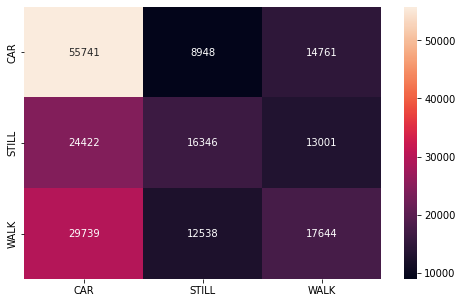

In [ ]:
confusionMatrix = confusion_matrix(y1, y_pred)
df_cm = pd.DataFrame(confusionMatrix, index=[i for i in ['CAR', 'STILL', 'WALK']], columns=[i for i in ['CAR', 'STILL', 'WALK']])

plt.figure(figsize=(8,5))
sn.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
score = v_measure_score(y1, y_pred)
score

0.017048798426949577

In [ ]:
svm_model = SVC()
svm_model.fit(X, y)
y_pred_svm = svm_model.predict(X1)

print("Accuracy: %.2f"%accuracy_score(y1, y_pred_svm))
print("Recall: %.2f"%recall_score(y1, y_pred_svm, average='macro'))
print("Precision: %.2f"%precision_score(y1, y_pred_svm, average='macro'))
print("F1-Score: %.2f"%f1_score(y1, y_pred_svm, average='macro'))

In [ ]:
confusionMatrixSvm = confusion_matrix(y1, y_pred_svm)
df_cm_svm = pd.DataFrame(confusionMatrixSvm, index=[i for i in ['CAR', 'STILL', 'WALK']], columns=[i for i in ['CAR', 'STILL', 'WALK']])

plt.figure(figsize=(8,5))
sn.heatmap(df_cm_svm, annot=True, fmt='g')

In [ ]:
score = v_measure_score(y1, y_pred_svm)
score

In [ ]:
nn_model = MLPClassifier((200,200,))
nn_model.fit(X, y)
y_pred_nn = nn_model.predict(X1)

print("Accuracy: %.2f"%accuracy_score(y1, y_pred_nn))
print("Recall: %.2f"%recall_score(y1, y_pred_nn, average='macro'))
print("Precision: %.2f"%precision_score(y1, y_pred_nn, average='macro'))
print("F1-Score: %.2f"%f1_score(y1, y_pred_nn, average='macro'))

In [ ]:
confusionMatrixNn = confusion_matrix(y1, y_pred_nn)
df_cm_nn = pd.DataFrame(confusionMatrixNn, index=[i for i in ['CAR', 'STILL', 'WALK']], columns=[i for i in ['CAR', 'STILL', 'WALK']])

plt.figure(figsize=(8,5))
sn.heatmap(df_cm_nn, annot=True, fmt='g')

In [ ]:
score = v_measure_score(y1, y_pred_nn)
score

In [26]:
dt_model = DecisionTreeClassifier(max_depth=60)
dt_model.fit(X, y)
y_pred_dt = dt_model.predict(X1)

print("Accuracy: %.2f"%accuracy_score(y1, y_pred_dt))
print("Recall: %.2f"%recall_score(y1, y_pred_dt, average='macro'))
print("Precision: %.2f"%precision_score(y1, y_pred_dt, average='macro'))
print("F1-Score: %.2f"%f1_score(y1, y_pred_dt, average='macro'))

Accuracy: 0.32
Recall: 0.31
Precision: 0.32
F1-Score: 0.30


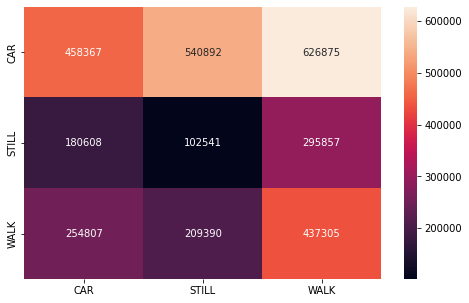

In [27]:
confusionMatrixDt = confusion_matrix(y1, y_pred_dt)
df_cm_dt = pd.DataFrame(confusionMatrixDt, index=[i for i in ['CAR', 'STILL', 'WALK']], columns=[i for i in ['CAR', 'STILL', 'WALK']])

plt.figure(figsize=(8,5))
sn.heatmap(df_cm_dt, annot=True, fmt='g')

In [28]:
score = v_measure_score(y1, y_pred_dt)
score

0.010958094986757315

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=65)
knn_model.fit(X, y)
y_pred_knn = knn_model.predict(X1)

print("Accuracy: %.2f"%accuracy_score(y1, y_pred_knn))
print("Recall: %.2f"%recall_score(y1, y_pred_knn, average='macro'))
print("Precision: %.2f"%precision_score(y1, y_pred_knn, average='macro'))
print("F1-Score: %.2f"%f1_score(y1, y_pred_knn, average='macro'))

Accuracy: 0.53
Recall: 0.36
Precision: 0.45
F1-Score: 0.30


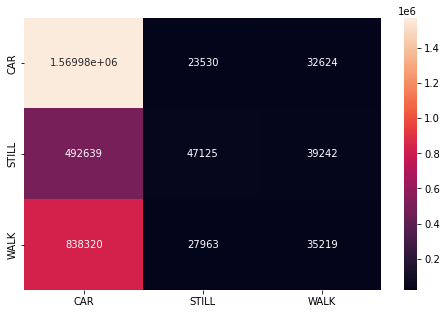

In [23]:
confusionMatrixKnn = confusion_matrix(y1, y_pred_knn)
df_cm_knn = pd.DataFrame(confusionMatrixKnn, index=[i for i in ['CAR', 'STILL', 'WALK']], columns=[i for i in ['CAR', 'STILL', 'WALK']])

plt.figure(figsize=(8,5))
sn.heatmap(df_cm_knn, annot=True, fmt='g')

In [24]:
score = v_measure_score(y1, y_pred_knn)
score

0.020588083655902176